In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

import settings as conf

In [3]:
supp_fig3_dir = os.path.join(conf.FIGURES_DIR, 'supp_fig3')
os.makedirs(supp_fig3_dir, exist_ok=True)

# Load PhenomeXcan vs Clinvar associations

In [4]:
phenomexcan_vs_clinvar_filename = os.path.join(conf.GENE_ASSOC_DIR, 'smultixcan_and_clinvar-z2.pkl.xz')
display(phenomexcan_vs_clinvar_filename)

'/mnt/phenomexcan_base/gene_assoc/smultixcan_and_clinvar-z2.pkl.xz'

In [5]:
phenomexcan_vs_clinvar = pd.read_pickle(phenomexcan_vs_clinvar_filename)

In [6]:
display(phenomexcan_vs_clinvar.shape)
display(phenomexcan_vs_clinvar.head())

(4091, 5106)

,Alzheimer's disease,Alpha-2-macroglobulin deficiency,"Otitis media, susceptibility to",p phenotype,Glucocorticoid deficiency with achalasia,Keratosis palmoplantaris papulosa,"Charcot-Marie-Tooth disease, type 2N","Epileptic encephalopathy, early infantile, 29",Combined oxidative phosphorylation deficiency 8,"Leukoencephalopathy, progressive, with ovarian failure",...,Retinitis pigmentosa 58,"Myopia 21, autosomal dominant",Paget disease of bone 6,Seborrhea-like dermatitis with psoriasiform elements,PEHO syndrome,Oocyte maturation defect 1,OOCYTE MATURATION DEFECT 6,OOCYTE MATURATION DEFECT 3,Acromelic frontonasal dysostosis,"NEURODEVELOPMENTAL DISORDER WITH MOVEMENT ABNORMALITIES, ABNORMAL GAIT, AND AUTISTIC FEATURES"
phenomexcan_traits,,,,,,,,,,,,,,,,,,,,,
20096_1-Size_of_red_wine_glass_drunk_small_125ml,0.651161,0.247607,3.820126,1.075217,0.009677,0.162067,1.670074,1.670074,0.273777,0.273777,...,0.292204,1.695379,0.355525,1.101905,0.379410,1.747519,0.272920,0.006041,0.194577,0.194577
2345-Ever_had_bowel_cancer_screening,0.544953,0.055165,0.373364,0.667099,1.731603,5.829613,0.000311,0.000311,0.872317,0.872317,...,0.871863,0.772939,0.120311,0.015428,0.332303,1.911665,2.069227,0.242165,0.392449,0.392449
N49-Diagnoses_main_ICD10_N49_Inflammatory_disorders_of_male_genital_organs_not_elsewhere_classified,2.352883,3.096874,0.208791,1.486795,0.166468,0.268138,2.304044,2.304044,0.007125,0.007125,...,0.020070,0.137331,0.744516,0.810886,0.222463,5.448538,0.087805,0.725028,0.155316,0.155316
100011_raw-Iron,2.905654,0.049563,11.132239,0.978171,0.428900,0.395410,0.199536,0.199536,0.638303,0.638303,...,0.000193,0.327350,0.436058,0.096868,0.173245,3.459105,0.144557,0.009105,0.015222,0.015222
5221-Index_of_best_refractometry_result_right,0.836999,0.071389,0.229481,0.340287,0.546314,2.319034,4.984327,4.984327,0.177313,0.177313,...,2.239274,1.115672,0.141618,0.012610,1.253595,0.031501,0.244870,0.001039,0.028283,0.028283


## QQplot

In [7]:
from scipy import stats
import plots

In [8]:
_all_values = pd.Series(phenomexcan_vs_clinvar.values.flatten())

In [9]:
_all_values.describe()

count    2.088865e+07
mean     1.330285e+00
std      7.561057e+00
min      0.000000e+00
25%      1.233913e-01
50%      5.334078e-01
75%      1.485715e+00
max      1.600000e+03
dtype: float64

In [10]:
all_values_quantiles = _all_values.quantile((0.95, 0.975, 0.99, 0.999, 0.9999))
display(all_values_quantiles)

0.9500      4.484652
0.9750      6.183966
0.9900      9.253712
0.9990     42.260161
0.9999    238.951206
dtype: float64

In [11]:
(theoretical_quantiles, sorted_input) = stats.probplot(_all_values, sparams=(1,), dist='chi2', fit=False, plot=None)

In [12]:
len(theoretical_quantiles), len(sorted_input)

(20888646, 20888646)

In [13]:
threshold = 30

theoretical_quantiles[theoretical_quantiles > threshold] = threshold

real_values = sorted_input
real_values[real_values > threshold] = threshold

df_plot = pd.DataFrame({'chi2': theoretical_quantiles, 'real': real_values})
display(df_plot.shape)
display(df_plot.head())

(20888646, 2)

,chi2,real
0,1.729618e-15,0.0
1,1.019083e-14,0.0
2,2.590471e-14,0.0
3,4.881854e-14,0.0
4,7.893232e-14,0.0


In [14]:
df_plot.describe().applymap(lambda x: f'{x:.3f}')

,chi2,real
count,20888646.000,20888646.000
mean,1.000,1.227
std,1.414,2.215
min,0.000,0.000
25%,0.102,0.123
50%,0.455,0.533
75%,1.323,1.486
max,30.000,30.000


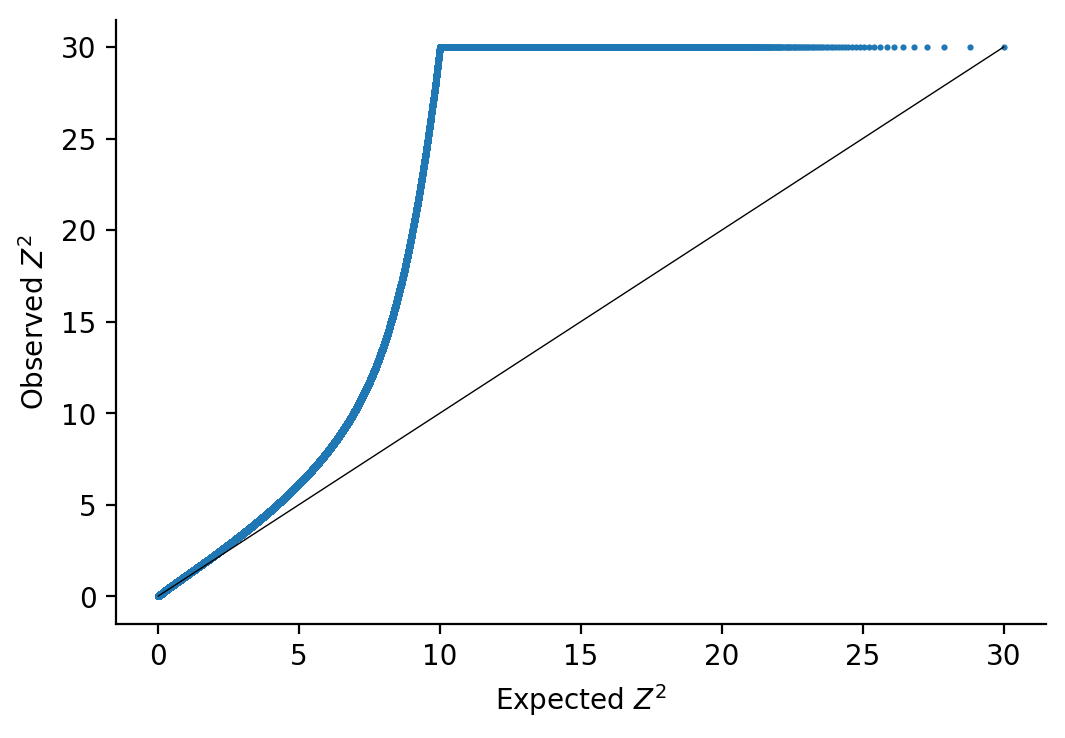

In [15]:
ax = plots.qqplot(df_plot, 'chi2', 'real', xlabel='Expected $Z^2$', ylabel='Observed $Z^2$', s=5, linewidth=0)
#ax.set_xlim([0, 20])
# ax.set_title('QQplot of UKB/ClinVar $Z^2$')

plt.savefig(os.path.join(supp_fig3_dir, 'supp_fig3.pdf'), bbox_inches='tight')